**Imports**

In [ ]:
import tensorflow as tf
import numpy as np
import rcwa_utils
import tensor_utils
import solver
import matplotlib.pyplot as plt

**Loss Function Definition**

In [ ]:
def focal_spot():

  # Global parameters dictionary.
  global params

  # Generate permittivity and permeability distributions.
  ER_t, UR_t = solver.generate_coupled_cylindrical_resonators(r_x_var, r_y_var, params)

  # Simulate the system.
  outputs = solver.simulate(ER_t, UR_t, params)
  field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
  focal_plane = solver.propagate(params['input'] * field, params)
  index = (params['pixelsX'] * params['upsample']) // 2
  f1 = tf.abs(focal_plane[0, index, index])

  # Maximize the electric field magnitude at the desired focal spot.
  return -f1

**Setup and Initialize Variables**

In [ ]:
# Initialize global params dictionary.
params = solver.initialize_params(wavelengths = [632.0],
                      thetas = [0.0],
                      phis = [0.0],
                      pte = [1.0],
                      ptm = [0.0],
                      pixelsX = 31,
                      pixelsY = 31)
params['erd'] = 6.76 # Grating layer permittivity.
params['ers'] = 2.25 # Subtrate layer permittivity.
params['PQ'] = [5, 5] # Fourier Harmonics.
params['Nx'] = 128
params['Ny'] = params['Nx']
params['upsample'] = 11
params['f'] = 1.0 * params['Lx'] * params['pixelsX']

# Define the free-space propagator and input field distribution for the metasurface.
params['propagator'] = solver.make_propagator(params)
params['input'] = solver.define_input_fields(params)

# Define duty cycles for unit cells based on 4 coupled elliptical nanoposts.
var_shape = (1, params['pixelsX'], params['pixelsY'], 4)
r_x_initial = 0.175 * np.ones(shape = var_shape)
r_y_initial = r_x_initial
r_x_var = tf.Variable(r_x_initial, dtype = tf.float32)
r_y_var = tf.Variable(r_y_initial, dtype = tf.float32)

**Optimize**

In [ ]:
# Number of optimization iterations.
N = 500

# Define an optimizer and data to be stored.
opt = tf.keras.optimizers.Adam(learning_rate = 2E-4)
loss = np.zeros(N + 1)

# Compute initial loss and duty cycle.
loss[0] = focal_spot().numpy()
print('Loss: ' + str(loss[0]))
print('\nOptimizing...')

# Optimize.
for i in range(N):
  opt.minimize(focal_spot, var_list = [r_x_var, r_y_var])
  loss[i + 1] = focal_spot().numpy()

print('Loss: ' + str(loss[N]))

Loss: -1.0056780576705933

Optimizing...
Loss: -16.03118896484375


**Display Learning Curve**

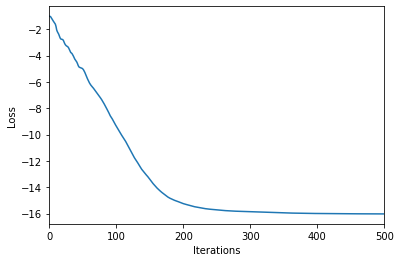

In [ ]:
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.xlim(0, N)
plt.show()

**Calculate the Focal Plane Intensity of the Optimized Structure**

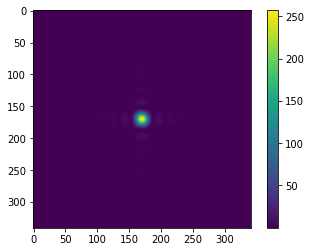

In [ ]:
ER_t, UR_t = solver.generate_coupled_cylindrical_resonators(r_x_var, r_y_var, params)
outputs = solver.simulate(ER_t, UR_t, params)
field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
focal_plane = solver.propagate(field, params)
plt.imshow(tf.abs(focal_plane[0, :, :]) ** 2)
plt.colorbar()